# Explore the dataset

In [8]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [9]:

class MinMaxScaler:
    def __init__(self, data, min_=0, max_=1) -> None:
        self.data_min = np.min(data)
        self.data_max = np.max(data)
        self.min_ = min_
        self.max_ = max_

    def transform(self, x):
        d_diff = self.data_max - self.data_min + 1e-32
        s_diff = self.max_ - self.min_
        return (x - self.data_min) / d_diff * s_diff + self.min_

    def inverse_transform(self, x):
        d_diff = self.data_max - self.data_min + 1e-32
        s_diff = self.max_ - self.min_
        return (x - self.min_) / s_diff * d_diff + self.data_min



class ChannelMinMaxScaler(MinMaxScaler):
    def __init__(self, data, axis_apply, min_=0, max_=1) -> None:
        super().__init__(data, min_, max_)
        self.data_min = np.nanmin(data, axis=axis_apply, keepdims=True)
        self.data_max = np.nanmax(data, axis=axis_apply, keepdims=True)
        

In [10]:
# plot utilies

def plot_field(field, vmin, vmax):
    '''field: shape [x, y]'''
    fig, axs = plt.subplots(4,4, figsize=(10,8))
    for i, ax in enumerate(axs.ravel()):
        im = ax.imshow(field[...,i].T, 
                cmap='rainbow',
                origin='lower',
                aspect='auto',
                vmin=vmin[i],
                vmax=vmax[i])
        ax.set_box_aspect(1)
        ax.axis('off')
        fig.colorbar(im)
    plt.tight_layout()
    plt.show()
    return fig


def plot_progression(data, name='Redi'):
    '''
    data to be plotted has shape [100, 100, t] t being time or parameter values
    '''
    plt.rcParams['text.usetex'] = False
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['font.size'] = 12
    
    batch_size = data.shape[-1] // 5
    fig, axs = plt.subplots(1, 5, figsize=(10,2))
    data = data[..., ::batch_size]
    for i, ax in enumerate(axs):
        if name is not None: # now data shape [100, 100, 2, t]:
            d = data[..., 0, i].T
            gm = np.nanmax(data[..., -1, i])
            gm_m = np.nanmin(data[..., -1, i])
            assert gm == gm_m
        else:
            d = data[..., i].T
        im = ax.imshow(d, 
                cmap='seismic',
                origin='lower',
                aspect='auto',
                vmin=np.nanmin(d),
                vmax=np.nanmax(d))
        ax.set_box_aspect(1)
        ax.axis('off')
        if name is not None:
            ax.set_title(r'${\kappa_{}}={:.2e}$'.format(name, gm))
        else:
            ax.set_title(r'$t={}$'.format(i*batch_size))
    cbar_ax = fig.add_axes([0.15, -0.05, 0.7, 0.05])
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label=r'Temperature $[^\circ C]$')
    cbar.set_label(r'Temperature $[^\circ C]$', fontsize=16) 
    return fig




In [11]:
# Load the data set

data = h5py.File('/pscratch/sd/y/yixuans/datatset/SOMA/thedataset-GM.hdf5', 'r')
print(data.keys())
print(len(data.keys()))

<KeysViewHDF5 ['forward_0', 'forward_1', 'forward_10', 'forward_11', 'forward_12', 'forward_13', 'forward_14', 'forward_15', 'forward_16', 'forward_17', 'forward_18', 'forward_19', 'forward_2', 'forward_20', 'forward_21', 'forward_22', 'forward_23', 'forward_24', 'forward_25', 'forward_26', 'forward_27', 'forward_28', 'forward_29', 'forward_3', 'forward_30', 'forward_31', 'forward_32', 'forward_33', 'forward_34', 'forward_35', 'forward_36', 'forward_37', 'forward_38', 'forward_39', 'forward_4', 'forward_40', 'forward_41', 'forward_42', 'forward_43', 'forward_44', 'forward_45', 'forward_46', 'forward_47', 'forward_48', 'forward_49', 'forward_5', 'forward_50', 'forward_51', 'forward_52', 'forward_53', 'forward_54', 'forward_55', 'forward_56', 'forward_57', 'forward_58', 'forward_59', 'forward_6', 'forward_60', 'forward_61', 'forward_62', 'forward_63', 'forward_64', 'forward_65', 'forward_66', 'forward_67', 'forward_68', 'forward_69', 'forward_7', 'forward_70', 'forward_71', 'forward_72',

In [13]:
# just to visually inspect the dataset
# create a folder for each forward run
# and plot out all 16 variables at each time step
# plot out the middle vertical layer

import os
from tqdm import tqdm
path = '/pscratch/sd/y/yixuans/'

# def extractData(data):
#     final = []
#     gm = []
#     for i in range(100):
#         d = data[f'forward_{i}'][:, :10, :, :, [10, -1]] # take all timesteps first 10 vertical levels and temperature only
#         gm.append(d[..., -1][0, 0, 50, 50]) # append GM values
#         final.append(d[..., 0])
#     return np.asarray(final), np.array(gm)

# data = h5py.File('/pscratch/sd/y/yixuans/datatset/SOMA/thedataset-GM.hdf5', 'r')
# temp, gm = extractData(data)
# np.savez('../tmp/temperatureGM.npz', temp=temp, gm=gm)


# data = np.load('../tmp/temperatureGM.npz')
# tmp = data['gm']
# print(tmp.shape)


def get_data(key):
    forward = data[key][...]



    mask1 = forward < -1e16
    mask2 = forward > 1e16
    mask = np.logical_or(mask1, mask2)


    forward[mask] = np.nan
    
    data_plot = forward[:, 10 , :, :, (10, 16)]
    data_plot = np.moveaxis(data_plot, 0, -1)


    return data_plot

data_gm = []
for k in tqdm(data.keys()):
    data_gm.append(get_data(k))


# for i in range(forward.shape[0]):
#     # scaler = ChannelMinMaxScaler(forward_0, (0, 1, 2, 3))
#     # forward_0 = scaler.transform(forward_0)


#     # import pickle

#     # with open('../tmp/SOMA_mask.pkl', 'wb') as f:
#     #     mask = {'mask1': mask1, 'mask2': mask2}
#     #     pickle.dump(mask, f)
#     for j in range(0, 60, 5):
#         print(j)
#         fig = plot_field(forward[28, j, :, :,: ], vmin=vmin, vmax=vmax)
#         if not os.path.exists(path + f'{k}/'):
#             os.makedirs(path + f'{k}/')
#         fig.savefig(path + f'{k}/{i}.pdf', format='pdf')
#         plt.show()
#         plt.close()
#     break
# break

# get the min max for all variables from the first example
# for i in range(forward_0.shape[-1]):
#     print((np.nanmin(forward_0[..., i]), np.nanmax(forward_0[..., i])))


# investigate where 0 is coming from in GM
# mask_0 = forward_0[...,-1] == 0
# a = forward_0
# a[mask_0] = 500
# for i in range(forward_0.shape[0]):
#     plt.imshow(a[i,0, ..., -1], cmap='seismic')
#     plt.show()



  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [04:21<00:00,  2.61s/it]


In [12]:
d = np.array(data_gm)
print(d.shape)
d = np.moveaxis(d, 0, -1)
print(d.shape)
gm = np.mean(d[29, :,:, 1, :], axis=(0,1))
idx = np.argsort(gm)
d = d[...,idx]
d = d[29]
print(d.shape)


fig  = plot_progression(d, 'GM')

fig.savefig('../eval_plots/gm_progression_temperature.pdf', format='pdf', bbox_inches='tight')

NameError: name 'data_gm' is not defined

In [6]:
# load prediction data
import pickle
import numpy as np 

with open('/pscratch/sd/y/yixuans/2023-07-26-true_pred.pkl', 'rb') as f:
    data = pickle.load(f)

with open('../tmp/SOMA_mask.pkl', 'rb') as f:
    mask = pickle.load(f)

mask = np.logical_or(mask['mask1'], mask['mask2'])
true = data['true'][0]
pred = data['pred'][0]

print(pred.shape)


true = np.transpose(true, axes=(0, 2, 3, 4, 1))
pred = np.transpose(pred, axes=(0, 2, 3, 4, 1))
print(pred.shape)

print(true.shape)
print(mask.shape)
mask_b = mask[0:1,0:1,:,:,0:1]
mask_b = np.broadcast_to(mask_b, true.shape)
print(mask_b.shape)
true[mask_b] = np.nan
pred[mask_b] = np.nan
print(true.shape, pred.shape)


(29, 16, 60, 100, 100)
(29, 60, 100, 100, 16)
(29, 60, 100, 100, 16)
(30, 60, 100, 100, 17)
(29, 60, 100, 100, 16)
(29, 60, 100, 100, 16) (29, 60, 100, 100, 16)


NameError: name 'plot_field' is not defined

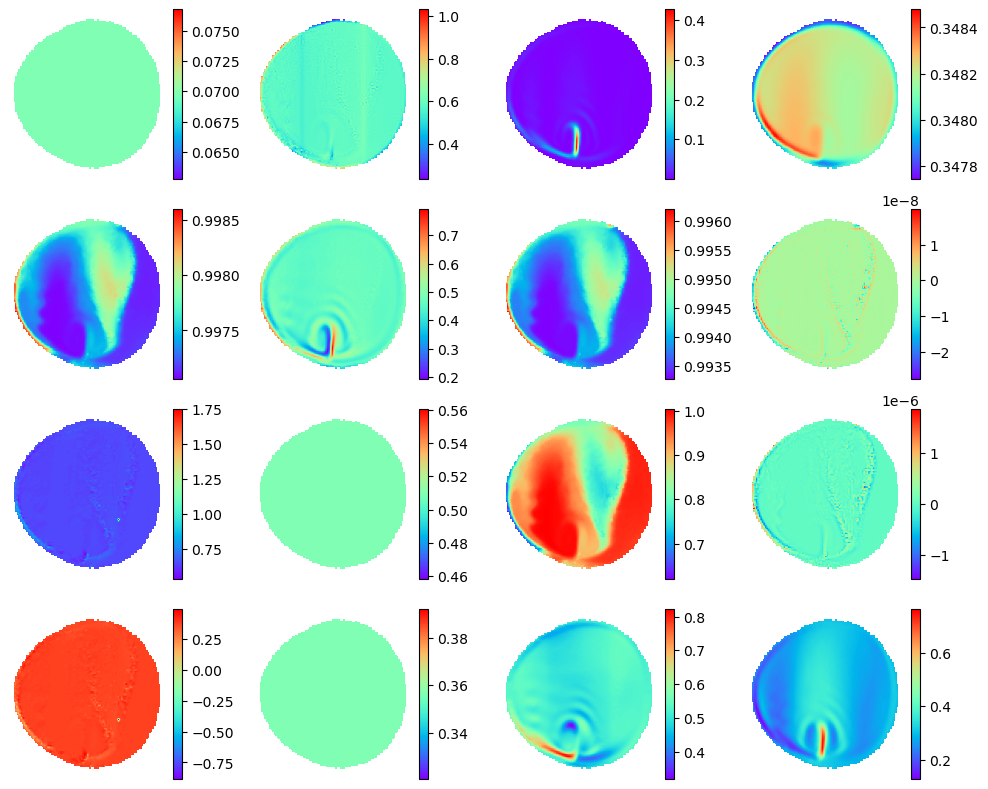

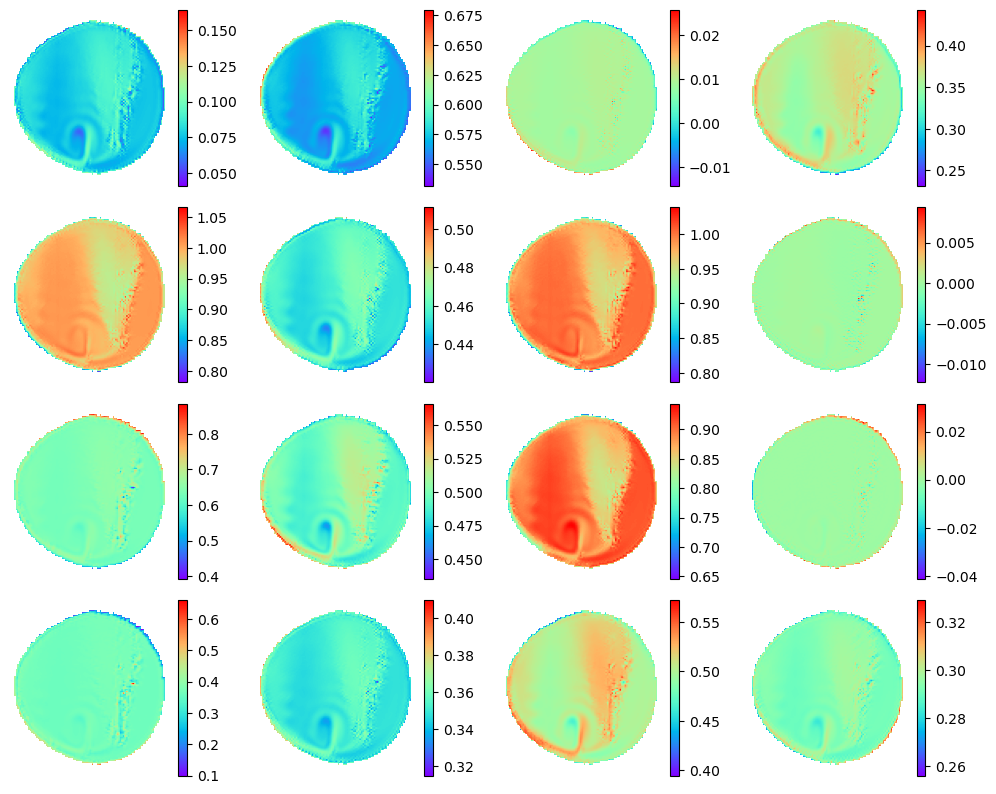

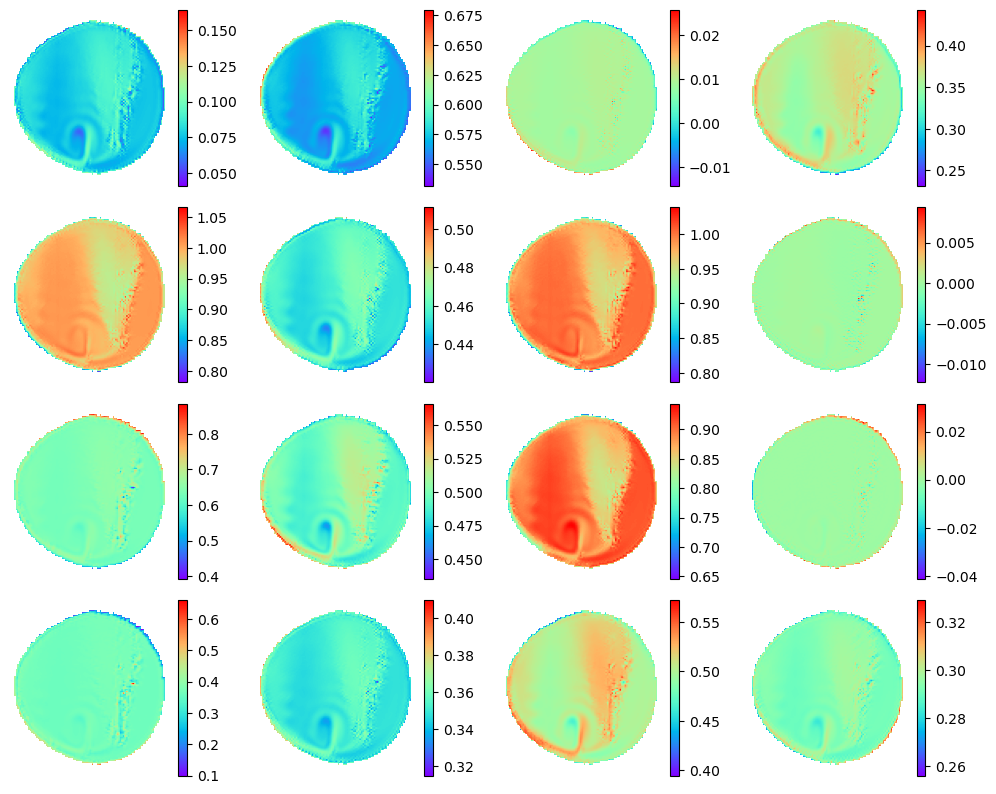

In [14]:
plot_field(true[0,0,...])
plot_field(pred[0,0, ...])

In [18]:
# report metric scores
from sklearn.metrics import r2_score

print(r2_score(np.nan_to_num(true.flatten()), np.nan_to_num(pred.flatten())))

: 

: 

In [6]:
# To plot neural adjoints

import numpy as np
import pickle

with open('../pred_results/adjRandLocs-BTTMDRAG.pkl', 'rb') as f:
    data = pickle.load(f)

adj = []
for i in range(5):
    adj.append(np.abs(data[f'adj_{i}']))
print(np.array(adj).shape)
print(np.mean(np.array(adj), axis=(0, 1)))

# import matplotlib.pyplot as plt
# for loc in range(5):
#     adj = np.abs(data[f'adj_{loc}'])
#     fig, ax = plt.subplots()
#     ax.set_box_aspect(1/1.62)
#     plt.rcParams['mathtext.fontset'] = 'stix'
#     plt.rcParams['font.family'] = 'STIXGeneral'
#     plt.rcParams['font.size'] = 20
#     plt.rcParams['axes.linewidth'] = 1

#     var_names = ['Layer Thickness', 'Salinity', 'Temperature', 'Zonal Velocity', 'Meridional Velociy'] 
#     values = np.mean(adj, axis=0)
#     from scipy.stats import sem
#     se = sem(adj, axis=0)
#     # ax.grid(which='major',  color='lightgray', linestyle='-.', linewidth=1.5)
#     ax.bar(var_names, values, yerr=se, color='steelblue', alpha=0.7)
#     ax.set_ylabel(r'$\frac{\partial y}{\partial p}$', fontsize=30)
#     ax.yaxis.label.set_rotation(90)
#     ax.set_xticklabels(var_names, rotation=45, fontsize=20)

#     fig.savefig(f'../eval_plots/L{loc}_adj_rank_GM_FD.pdf', format='pdf', bbox_inches='tight')

(5, 261, 5)
[1.8861487e-08 2.3671756e-08 1.9959664e-08 1.8486720e-08 2.4134504e-08]


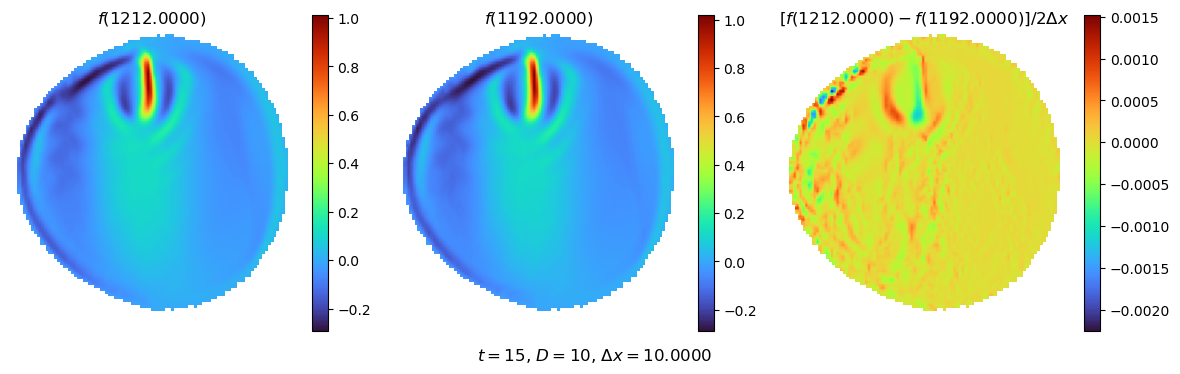

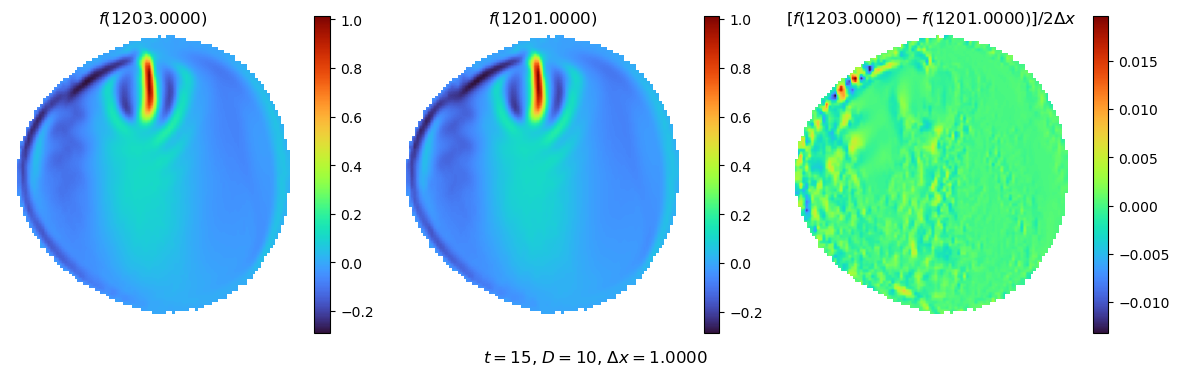

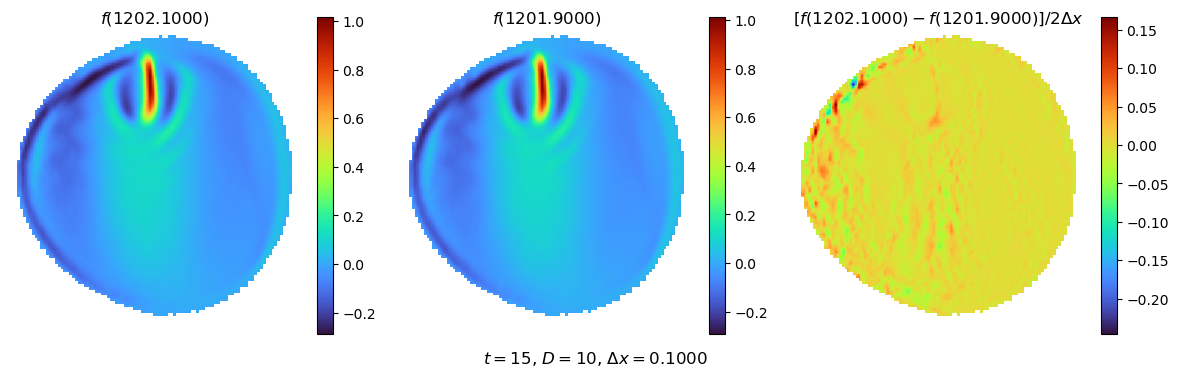

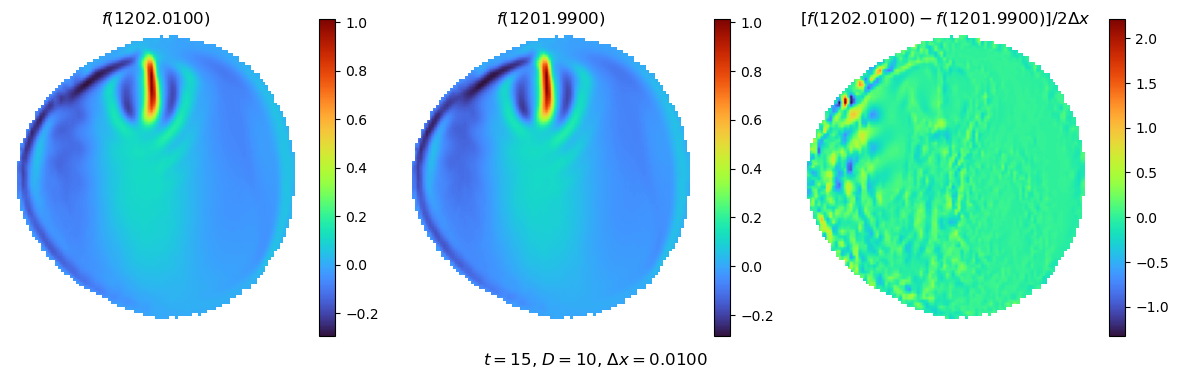

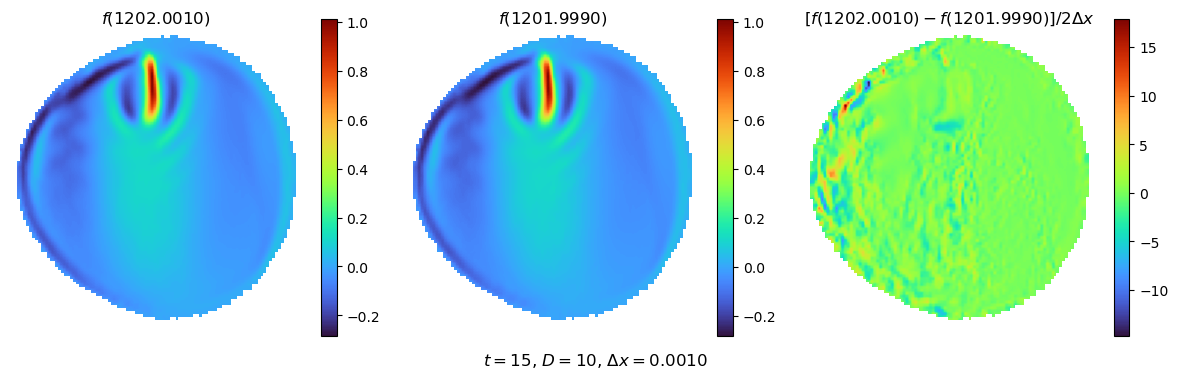

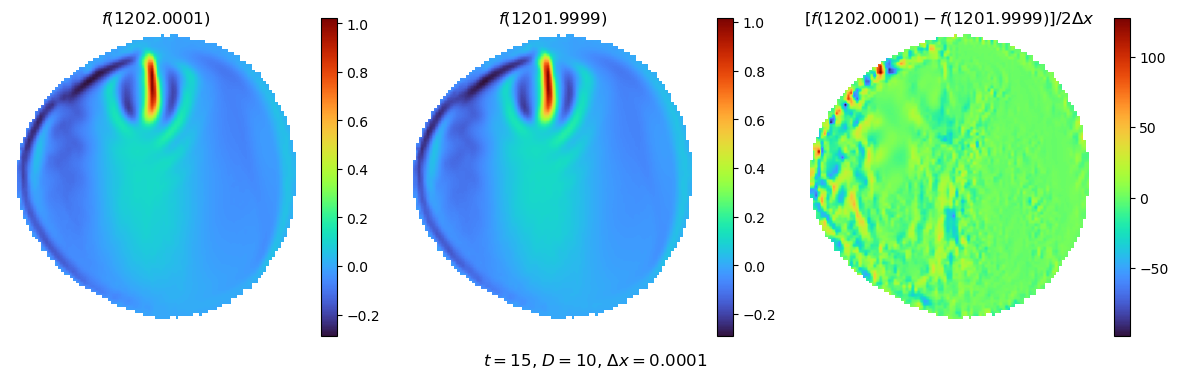

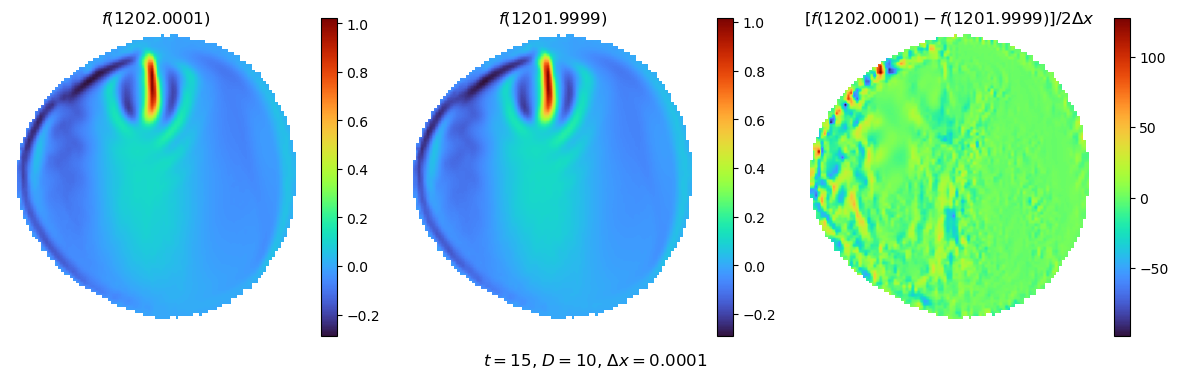

In [20]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# var_names = ['LayerThickness', 'Salinity', 'Temperature', 'ZonalVelocity', 'MeridionalVelociy']
names = ['x10.0', 'x1.0', 'x0.1', 'x0.01', 'x0.001', 'x0.0001', 'x0.0001-3']
difference = [] 
approx_d = []
stateValues = []
for name in names:
    data_path =  f'/pscratch/sd/y/yixuans/datatset/GM_FD/thedataset-GM_FD_{name}.hdf5'
    data = h5py.File(data_path, 'r')
    f_p = data['forward_1'][...]
    f_m = data['forward_2'][...]

    GM_p = f_p[15, 10, 50, 50, -1]
    GM_m = f_m[15, 10, 50, 50, -1]
    mask = f_p > 1e16 
    mask2= f_p < -1e16
    mask = np.logical_or(mask, mask2)

    f_p[mask] = np.nan
    f_m[mask] = np.nan

    var_idx = [3, 6, 10, 14, 15] 
    var_idx_in = var_idx + [-1]
    # print('Parameter value is {}'.format(f_p[...,var_idx_in]))

    f_p = np.transpose(f_p, axes=[4, 0, 1, 2, 3])[var_idx_in][4, 15, 10, ...] # specify the 2D field
    f_m = np.transpose(f_m, axes=[4, 0, 1, 2, 3])[var_idx_in][4, 15, 10, ...]
    d_f = (f_p - f_m) / (GM_p - GM_m)
    stateValues.append(f_p)
    difference.append((f_p - f_m))
    approx_d.append((f_p - f_m)/(GM_p - GM_m))
    fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))

    im=ax[0].imshow(f_p.T, cmap='turbo')
    ax[0].set_title(rf'$f({GM_p:.4f})$')
    plt.colorbar(im, ax=ax[0])
    im2=ax[1].imshow(f_m.T, cmap='turbo')
    ax[1].set_title(rf'$f({GM_m:.4f})$')
    plt.colorbar(im2, ax=ax[1])
    im3=ax[2].imshow(d_f.T, cmap='turbo')
    ax[2].set_title(rf'$[f({GM_p:.4f}) - f({GM_m:.4f})] / 2\Delta x$')
    plt.colorbar(im3, ax=ax[2])
    # print(f_p[-1, 0, 40, 50, 50].T)
    for a in ax:
        a.axis('off')
    plt.tight_layout()
    plt.suptitle(rf'$t=15$, $D = 10$, $\Delta x = {(GM_p - GM_m)/2:.4f}$', y=0)
    plt.show()

[(30, 30), (30, 31), (29, 30), (29, 29)]


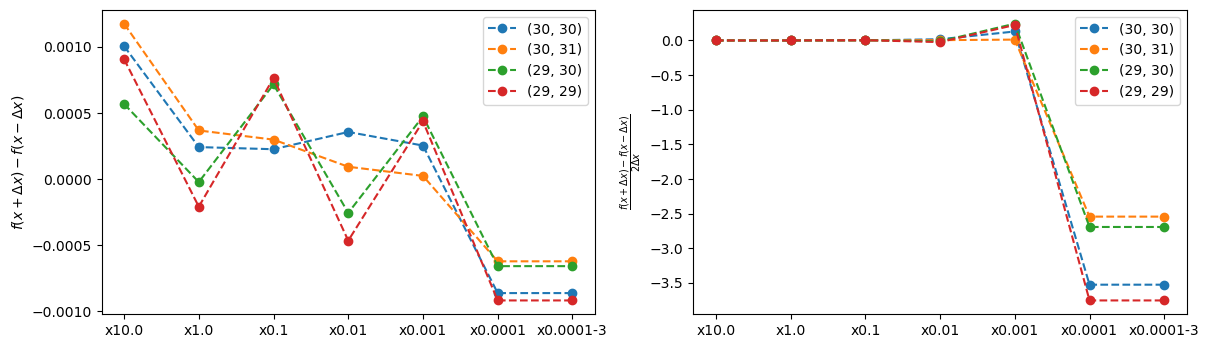

In [21]:
def plotTrend(diff, drev, xtickNames, locs, allAvg):
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    for i, df in enumerate(diff):
        ax[0].plot(np.arange(len(df)), df, '--o', label=f'({locs[i][0]}, {locs[i][1]})')
        ax[0].set_xticks(np.arange(len(xtickNames)))
        ax[0].set_xticklabels(xtickNames)
        ax[0].set_ylabel(r'$f(x+\Delta x) - f(x - \Delta x)$')
    
    for i, dv in enumerate(drev): 

        ax[1].plot(np.arange(len(dv)), dv, '--o', label=f'({locs[i][0]}, {locs[i][1]})')
        ax[1].set_xticks(np.arange(len(xtickNames)))
        ax[1].set_xticklabels(xtickNames)
        ax[1].set_ylabel(r'$\frac{f(x+\Delta x) - f(x - \Delta x)}{2\Delta x}$')
    
    #ax[0].plot(np.arange(len(allAvg[0])), allAvg[0], '--ko', label='All Loc. Avg.', linewidth=3)
    #ax[1].plot(np.arange(len(allAvg[1])), allAvg[1], '--ko', label='All Loc. Avg.', linewidth=3)
    #ax[0].set_ylim(-1, 1)
    
    for a in ax:
        a.set_box_aspect(1/1.62)
        a.grid(True, which='minor', linestyle=':', linewidth=0.3, color='gray', alpha=0.4)
        a.legend()
    
    

def sample_locs(n_samples, mask, x_range=100, y_range=100):
    '''
    sample horizontal locations for adjoint calculation
    we only sample x, y locations as of now and use a fixed
    vertical depth for reporting the results
    '''
    sampled_locs = []
    while len(sampled_locs) < n_samples:
        x_sample = np.random.randint(low=0, high=x_range)
        y_sample = np.random.randint(low=0, high=y_range)
        if mask[x_sample][y_sample] == False: # check if the sampled location is within the domain of interest
            sampled_locs.append((x_sample, y_sample))
    return sampled_locs

locs = sample_locs(5, mask[0,0,:,:,0])
locs = [(30, 30), (30, 31), (29, 30), (29, 29)]
print(locs)

diff = []
drev = []

diffAvg = [np.nanmean(d) for d in difference]
drvAvg = [np.nanmean(d) for d in approx_d]
allAvg = [diffAvg, drvAvg]

for l in locs:
    diff.append([d[l] for d in difference])
    drev.append([d[l] for d in approx_d])




plotTrend(diff, drev, names, locs, allAvg)


In [24]:
diffTwoRuns = difference[-2] - difference[-1]
mask = np.isnan(diffTwoRuns)
print(np.unique(diffTwoRuns[~mask]))
print(np.nanmean(diffTwoRuns))

[0.]
0.0


In [6]:
# plot time temperature time progression 
import h5py
import matplotlib.patches as patches

name = 'x0.01'
names = ['x10.0', 'x1.0', 'x0.1', 'x0.01', 'x0.001']
dataList = []
for n in names:
    data = h5py.File(f'/pscratch/sd/y/yixuans/datatset/GM_FD/thedataset-GM_FD_{name}.hdf5', 'r')['forward_1'][..., [3, 6, 10, 14, 15]]
    dataList.append(data)
varNames = ['Layer Thickness', 'Salinity', 'Temperature', 'Zonal Velocity', 'Meridional Velociy'] 
print(data.shape)

def plotXvP(dataList, gm, locs, ifAvg=False, stateName='Temperature'):
    '''
    data: 2D field at T=15 D=10
    locs: location in horizontal plane to look at
    '''
    fig, ax = plt.subplots(1,2, figsize=(11, 4))
    if ifAvg:
        d = np.array([data[locs[0]-5:locs[0]+5, locs[1]-5:locs[1]+5] for data in dataList])
        d_std = np.std(d, axis=(1,2))
        d = np.mean(d, axis=(1,2))
    else:
        d = [data[locs[0], locs[1]] for data in dataList]
    dField = dataList[0]

    ax[0].plot(gm, d, linestyle='--', marker='o')
    if ifAvg:
        ax[0].fill_between(gm, d - d_std, d + d_std, alpha=0.3)
    # ax[0].legend()
    ax[0].set_box_aspect(1/1.62)
    ax[0].grid(True, 'both', color='lightgray', linestyle='-.')
    ax[0].set_xlabel('GM Values')
    ax[0].set_ylabel(f'{stateName}')
    # ax[0].set_xticks(np.arange(len(d)))
    # ax[0].set_xticklabels(ticklabels, rotation=45)


    mask = dField > 1e16 
    mask2= dField < -1e16
    mask = np.logical_or(mask, mask2)
    dField[mask] = np.nan
    im = ax[1].imshow(dField.T, cmap='turbo')
    if ifAvg:
        rect = patches.Rectangle((locs[0]-5, locs[1]-5), 10, 10, linewidth=2, edgecolor='k', facecolor='none')
        ax[1].add_patch(rect)
    else:
        ax[1].scatter(locs[0], locs[1], marker='o', color='k', s=100)
    ax[1].axis('off')
    # fig.suptitle(f'{varNames[var_idx]} Progression')
    plt.colorbar(im)
    return fig

def plotTimeProgression(dataList, var_idx, locs, level=10):
    '''
    data: [T, Z, X, Y, U]
    var_idx: the state variable to look at
    locs: location in horizontal plane to look at
    '''
    fig, ax = plt.subplots(1,2, figsize=(11, 4))
    for i, data in enumerate(dataList):
        print(data.shape)
        d = data[:, level, locs[0], locs[1], var_idx]
        dField = data[15, level, :, :, var_idx]
        ax[0].plot(d,  label=names[i])
    ax[0].legend()
    ax[0].set_box_aspect(1/1.62)
    ax[0].grid(True, 'both', color='lightgray', linestyle='-.')
    ax[0].set_xlabel('Time Steps [Day]')
    ax[0].set_ylabel(f'{varNames[var_idx]} at ({locs[0]}, {locs[1]})')


    mask = dField > 1e16 
    mask2= dField < -1e16
    mask = np.logical_or(mask, mask2)
    dField[mask] = np.nan
    im = ax[1].imshow(dField.T, cmap='turbo')
    ax[1].scatter(locs[0], locs[1], marker='o', color='k', s=100)
    ax[1].axis('off')
    fig.suptitle(f'{varNames[var_idx]} Progression')
    plt.colorbar(im)
    return fig

# fig = plotTimeProgression(dataList, 2, (30, 30))
# fig = plotXvP(stateValues, (30, 30))



(30, 60, 100, 100, 5)


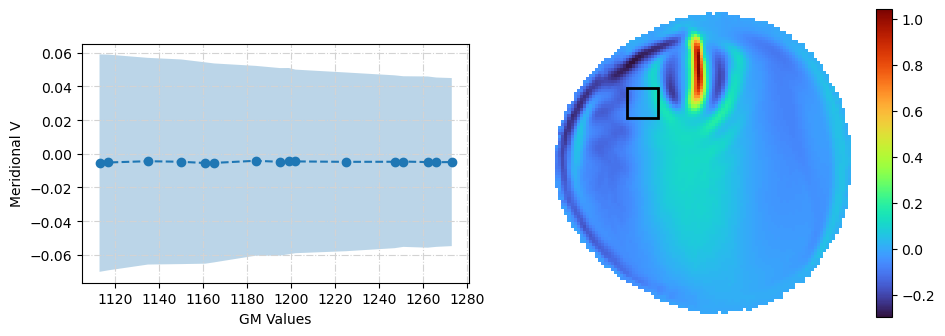

In [22]:
dataGM = h5py.File('/pscratch/sd/y/yixuans/datatset/SOMA/thedataset-GM.hdf5')
temperautre = []
gm = []
for i in range(100):
    d = dataGM[f'forward_{i}'][15, 10, :, :, [3, 6, 10, 14, 15 ,16]][..., [4, -1]] # last axis 10 being the temperature
    temperautre.append(d[..., 0])
    gm.append(d[..., -1][30, 30])


gm = np.array(gm)
temperautre = np.array(temperautre)



idx = np.argsort(gm)
gm = gm[idx]
temperautre = temperautre[idx]
mask = np.logical_and(gm >= 1100, gm<=1300)
gm = gm[mask]
temperautre = temperautre[mask,...]

fig = plotXvP(temperautre, gm, (30, 30), ifAvg=True, stateName='Meridional V')